<span style="font-size:30px; font-weight:300">Cancer Cells Identification with Inception v3</span>

**Acute lymphocytic leukemia (ALL)** is a form of blood and bone marrow cancer. The marrow is the spongy tissue within bones that produces blood cells. Acute lymphocytic leukemia, also known as acute lymphoblastic leukemia, is the most common form of cancer in children. Adults may also develop acute lymphocytic leukemia, though the likelihood of a cure is greatly reduced. The term "acute" in acute lymphocytic leukemia refers to the disease's rapid progression and the production of immature blood cells rather than mature ones.

**Inception v3** is a convolutional neural network that was first developed as part of the ImageNet Recognition Challenge. It began as a Googlenet module and is used to aid in image analysis and object detection. Inception, like ImageNet, is a database of categorized visual objects that aids in the classification of objects in the world of computer vision. One such use is in life sciences, where it assists in the study of leukemia.

## Setup

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# utilities
import os
from tqdm import tqdm

# machine learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

The following sections define the key configuration parameters that will be used.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 128
CLASS_NAMES = ["ALL", "Normal"]

## Load Data

In [ ]:
images = []
labels = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/data/C-NMC_Leukemia/training_data'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename))
        if filename.find('all') != -1:
            labels.append(0)
        elif filename.find('hem') != -1:
            labels.append(1)

df = pd.DataFrame({'images' : images, 'labels' : labels})

print(df)

                                                  images  labels
0      /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       0
1      /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       0
2      /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       0
3      /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       0
4      /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       0
...                                                  ...     ...
10656  /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       1
10657  /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       1
10658  /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       1
10659  /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       1
10660  /content/drive/MyDrive/data/C-NMC_Leukemia/tra...       1

[10661 rows x 2 columns]


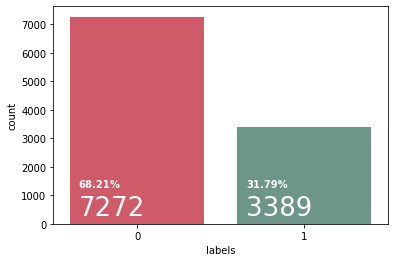

In [ ]:
ax = sns.countplot(x='labels', data=df, palette=['#E2485A', '#679B8B'])
for p in ax.patches:
    ax.annotate('{:d}'.format(p.get_height()), (p.get_x() + 0.05, 300), fontsize = 26, fontweight = 100, color = '#ffffff')
    ax.annotate('{:.2f}%'.format(p.get_height()/len(df)*100), (p.get_x() + 0.05, 1300), fontsize = 10, fontweight = 700, color = '#ffffff')

There are 10,661 pictures in total. As can be seen from the chart, the dataset is imbalance. The majority are regular cells, with 7272 being cancer cells. Here are 25 images from the training dataset that were chosen at random.

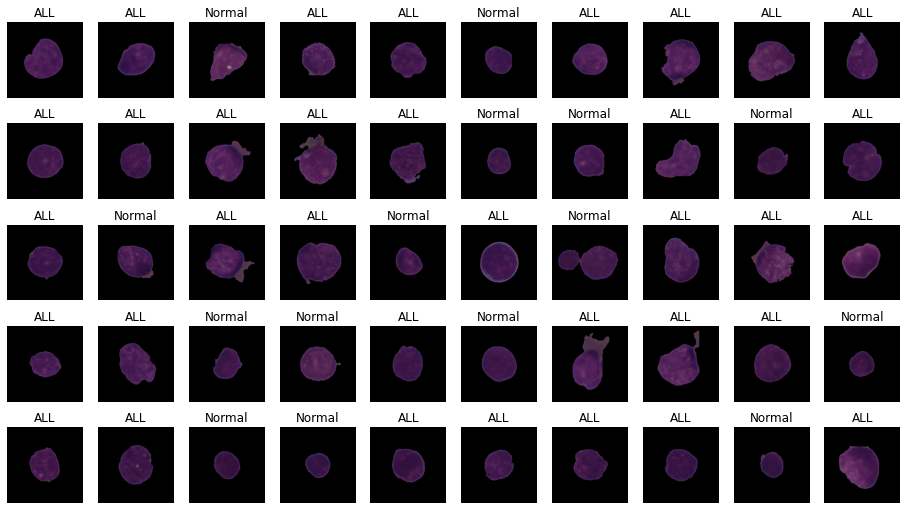

In [ ]:
preview = df.sample(n=50)

plt.figure(figsize=(16, 9))
for i in range(len(preview)):
    ax = plt.subplot(5, 10, i + 1)
    img = plt.imread(preview['images'].iloc[i])
    plt.imshow(img)
    lbl = preview['labels'].iloc[i]
    plt.axis("off")
    plt.title(CLASS_NAMES[lbl])

## Generate Dataset

In [ ]:
labels = tf.keras.utils.to_categorical(np.array(labels), 2)
ds = tf.data.Dataset.from_tensor_slices((images,labels))

In [ ]:
def process_dataset(image,label):
    img = tf.io.read_file(image)
    img = tf.io.decode_bmp(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE,IMG_SIZE])
    return img, label

ds = ds.map(process_dataset, num_parallel_calls=AUTOTUNE)

Let us use 80% of the images for training and 20% for validation.

In [ ]:
val_size = int(len(images) * 0.2)
ds = ds.shuffle(10000)

val_ds = ds.take(val_size)
train_ds = ds.skip(val_size)

print('Training dataset :',tf.data.experimental.cardinality(train_ds).numpy())
print('Validation dataset :',tf.data.experimental.cardinality(val_ds).numpy())

Training dataset : 8529
Validation dataset : 2132


In [ ]:
def prepare_for_training(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

The RGB channel values are between [0, 255]. This is not an ideal setting for a neural network. We will use a Rescaling layer to standardize values to be in the [0, 1] range and map it to the dataset.

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## Build Model From Inception V3

Download the Inception v3 model from TensorFlow Hub and set ` trainable=False ` to freeze the variables in the feature extractor layer. The Inception v3 layer is then wrapped in a ` tf.keras.Sequential ` model, and a new classification layer is added.

In [ ]:
inception_v3 = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'

inception_v3_model = tf.keras.Sequential([
    hub.KerasLayer(inception_v3, output_shape=[2048], input_shape=(IMG_SIZE, IMG_SIZE,3), trainable=False)
])

In [ ]:
model = tf.keras.Sequential([
    
    inception_v3_model,
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    layers.Dense(2, activation = "softmax")
])

model.compile(
    loss="categorical_crossentropy", 
    metrics = ['accuracy'], 
    optimizer = 'adam'
)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

## Correct Imbalance Data

As previously shown, the data was unbalanced. The weight for class 0 (ALL) is slightly greater than the weight for class 1 (Normal). We will correct this by using class weighting, as the CNN works better with balanced training data.

In [ ]:
train_0 = len(df[df.labels == 0])
train_1 = len(df[df.labels == 1])
train_total = train_0 + train_1

initial_bias = np.log([train_0 / train_1])

weight_0 = (1 / train_0) * (train_total) / 2.0
weight_1 = (1 / train_1) * (train_total) / 2.0

class_weight = {0: weight_0, 1: weight_1}

print("Total ALL: " + format(train_0))
print("Total Normal: " + format(train_1))
print("Initial bias: {:.5f}".format(initial_bias[0]))
print("Weight for class 0: {:.2f}".format(weight_0))
print("Weight for class 1: {:.2f}".format(weight_1))

Total ALL: 7272
Total Normal: 3389
Initial bias: 0.76350
Weight for class 0: 0.73
Weight for class 1: 1.57


## Train the model

Set an early stopping callback to halt the training process when the model becomes stagnant, or even worse, when the model begins to overfit. The checkpoint callback saves the model's optimal weights, so that the next time we want to use the model, we don't have to train it again.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("model.h5", verbose = 1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(verbose = 1, patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    epochs = 100,
    validation_data = val_ds,
    callbacks = callbacks,
    class_weight = class_weight
)

Epoch 1/100
267/267 [==============================] - 3785s 7s/step - loss: 1.0876 - accuracy: 0.5940 - val_loss: 0.5600 - val_accuracy: 0.7777

Epoch 00001: val_loss improved from inf to 0.55999, saving model to model.h5
Epoch 2/100
267/267 [==============================] - 10s 38ms/step - loss: 0.5646 - accuracy: 0.7278 - val_loss: 0.5314 - val_accuracy: 0.8007

Epoch 00002: val_loss improved from 0.55999 to 0.53141, saving model to model.h5
Epoch 3/100
267/267 [==============================] - 10s 38ms/step - loss: 0.5289 - accuracy: 0.7775 - val_loss: 0.5262 - val_accuracy: 0.8147

Epoch 00003: val_loss improved from 0.53141 to 0.52624, saving model to model.h5
Epoch 4/100
267/267 [==============================] - 10s 38ms/step - loss: 0.5249 - accuracy: 0.7765 - val_loss: 0.5277 - val_accuracy: 0.8077

Epoch 00004: val_loss did not improve from 0.52624
Epoch 5/100
267/267 [==============================] - 10s 38ms/step - loss: 0.5114 - accuracy: 0.7878 - val_loss: 0.5221 - va

In [ ]:
val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 84.60%


## Visualize Training Results

Our model is approximately 87% accurate. Let's create plots of loss and accuracy on the training and validation sets.

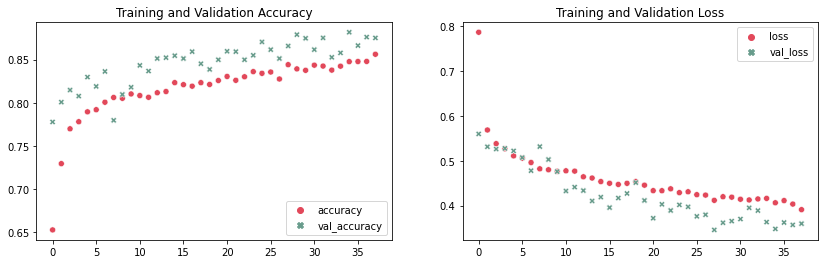

In [ ]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
sns.scatterplot(data=history_df[['accuracy','val_accuracy']], palette=['#E2485A', '#679B8B']);
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
sns.scatterplot(data=history_df[['loss','val_loss']], palette=['#E2485A', '#679B8B'])
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
model.save('LeuMod01')

INFO:tensorflow:Assets written to: LeuMod01/assets


INFO:tensorflow:Assets written to: LeuMod01/assets


In [ ]:
model.save('/content/drive/MyDrive/cancer_detector.h5')